# TPC DS scale factor 10 - Apache Spark acceleration on GPU with RAPIDS Spark

based on https://colab.research.google.com/github/LucaCanali/Miscellaneous/blob/master/Performance_Testing/TPCDS_PySpark/Labs_and_Notes/TPCDS_PySpark_getstarted.ipynb#scrollTo=6bab7772

# Install packages

In [1]:
spark_version='3.5.0'
rapids_version='24.08.1'
scala_version='2.12'

In [2]:
%pip install --quiet \
  tpcds_pyspark \
  pyspark=={spark_version} \
  sparkmeasure \
  pandas \
  matplotlib

Note: you may need to restart the kernel to use updated packages.


# Import modules

In [3]:
import os
from importlib.resources import files
from pyspark.sql import SparkSession
from tpcds_pyspark import TPCDS
import pandas as pd

In [4]:
tpcds_pyspark_files = files('tpcds_pyspark')

# Download TPC-DS 10GiB Scale Parquet Dataset

In [5]:
if not os.path.isdir('tpcds_10'):
  if not os.path.isfile('tpcds_10.zip'):
    !wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/TPCDS/tpcds_10.zip
  !unzip -q tpcds_10.zip

# Init a SparkSession with RAPIDS Spark

In [6]:
spark = (
    SparkSession.builder
      .appName('TPCDS PySpark RAPIDS=ON/OFF')
      .config('spark.driver.memory', '5g')
      .config('spark.plugins', 'com.nvidia.spark.SQLPlugin')
      .config('spark.jars', tpcds_pyspark_files.joinpath(f"spark-measure_{scala_version}-0.24.jar"))
      .config('spark.jars.packages', f"com.nvidia:rapids-4-spark_{scala_version}:{rapids_version}")
      .getOrCreate()
)


24/10/22 16:35:39 WARN Utils: Your hostname, e780a48-lcedt resolves to a loopback address: 127.0.1.1; using 10.112.215.249 instead (on interface enp36s0f0)
24/10/22 16:35:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/gshegalov/gits/NVIDIA/spark-rapids-examples/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/gshegalov/.ivy2/cache
The jars for the packages stored in: /home/gshegalov/.ivy2/jars
com.nvidia#rapids-4-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e6478563-b7f6-4827-b358-fd3bac8b289f;1.0
	confs: [default]
	found com.nvidia#rapids-4-spark_2.12;24.08.1 in central
:: resolution report :: resolve 66ms :: artifacts dl 2ms
	:: modules in use:
	com.nvidia#rapids-4-spark_2.12;24.08.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-e6478563-b7f6-4827-b358-

# Verify SQL Acceleration on GPU can be enabled by checking the query plan and the GPU RAM in the "Resources" tab

In [7]:
spark.conf.set('spark.rapids.sql.enabled', True)
sum_df = spark.range(1000).selectExpr('SUM(*)')
sum_df.collect()
sum_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   GpuColumnarToRow false, [loreId=22]
   +- GpuHashAggregate (keys=[], functions=[gpubasicsum(id#0L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=21]
      +- GpuShuffleCoalesce 1073741824, [loreId=20]
         +- ShuffleQueryStage 0
            +- GpuColumnarExchange gpusinglepartitioning$(), ENSURE_REQUIREMENTS, [plan_id=64], [loreId=17]
               +- GpuHashAggregate (keys=[], functions=[partial_gpubasicsum(id#0L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=16]
                  +- GpuRange (0, 1000, step=1, splits=64)
+- == Initial Plan ==
   HashAggregate(keys=[], functions=[sum(id#0L)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=11]
      +- HashAggregate(keys=[], functions=[partial_sum(id#0L)])
         +- Range (0, 1000, step=1, splits=64)




In [8]:
# https://github.com/LucaCanali/Miscellaneous/tree/master/Performance_Testing/TPCDS_PySpark/tpcds_pyspark/Queries

# queries = None to run all (takes much longer)
queries = None
queries = [
    'q14a',
    'q14b',
    'q23a',
    'q23b',
    # 'q24a',
    # 'q24b',
    # 'q88',
]


In [9]:
tpcds = TPCDS(data_path='./tpcds_10', num_runs=1, queries_repeat_times=1, queries=queries)

sparkMeasure jar path: /home/gshegalov/gits/NVIDIA/spark-rapids-examples/.venv/lib/python3.10/site-packages/tpcds_pyspark/spark-measure_2.12-0.24.jar
TPCDS queries path: /home/gshegalov/gits/NVIDIA/spark-rapids-examples/.venv/lib/python3.10/site-packages/tpcds_pyspark/Queries


24/10/22 16:35:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Register TPC-DS tables before running queries

In [10]:
tpcds.map_tables()

Creating temporary view catalog_returns


24/10/22 16:35:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Creating temporary view catalog_sales
Creating temporary view inventory
Creating temporary view store_returns
Creating temporary view store_sales
Creating temporary view web_returns
Creating temporary view web_sales
Creating temporary view call_center
Creating temporary view catalog_page
Creating temporary view customer
Creating temporary view customer_address
Creating temporary view customer_demographics
Creating temporary view date_dim
Creating temporary view household_demographics
Creating temporary view income_band
Creating temporary view item
Creating temporary view promotion
Creating temporary view reason
Creating temporary view ship_mode
Creating temporary view store
Creating temporary view time_dim
Creating temporary view warehouse
Creating temporary view web_page
Creating temporary view web_site


# Measure Apache Spark CPU

In [11]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', False)
%time tpcds.run_TPCDS()


Run 0 - query q14a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-22 16:35:52
...Elapsed Time = 9.74 sec
...Executors Run Time = 156.48 sec
...Executors CPU Time = 89.15 sec
...Executors JVM GC Time = 33.96 sec
...Average Active Tasks = 16.1

Run 0 - query q14b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-22 16:36:06
...Elapsed Time = 5.33 sec
...Executors Run Time = 90.99 sec
...Executors CPU Time = 57.31 sec
...Executors JVM GC Time = 23.23 sec
...Average Active Tasks = 17.1

Run 0 - query q23a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-22 16:36:13
...Elapsed Time = 8.17 sec
...Executors Run Time = 190.32 sec
...Executors CPU Time = 121.75 sec
...Executors JVM GC Time = 49.26 sec
...Average Active Tasks = 23.3

Run 0 - query q23b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-22 16:36:22
...Elapsed Time = 8.79 sec
...Executors Run Time = 214.06 sec
...Executors CPU Time = 144.9 sec
...Executors JVM GC Time = 49.19 sec
...Average Active Tasks = 24.3
CPU times: user 109 ms, sys: 32.7 ms, total: 142 ms
Wall time: 40 s


In [12]:
cpu_grouped_results = tpcds.grouped_results_pdf.copy()

In [13]:
cpu_grouped_results

,query,numStages,numTasks,elapsedTime,stageDuration,executorRunTime,executorCpuTime,executorDeserializeTime,executorDeserializeCpuTime,resultSerializationTime,...,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleTotalBytesRead,shuffleLocalBytesRead,shuffleRemoteBytesRead,shuffleRemoteBytesReadToDisk,shuffleBytesWritten,shuffleRecordsWritten,avg_active_tasks,elapsed_time_seconds
0,q14a,30,838,9738,18479,156477,89150,7139,2720,123,...,551,0,878437913,878437913,0,0,875325021,62516924,16,9
1,q14b,24,636,5334,8670,90986,57312,3065,1582,109,...,513,0,1013592969,1013592969,0,0,529675847,40865273,17,5
2,q23a,18,621,8167,13710,190322,121748,2091,1271,210,...,2269,0,1115089630,1115089630,0,0,1085198863,41990073,23,8
3,q23b,21,690,8793,17628,214062,144896,3687,1623,98,...,4779,0,1200330085,1200330085,0,0,1097570340,42452502,24,8


# Measure Apache Spark GPU

In [14]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', True)
%time tpcds.run_TPCDS()


Run 0 - query q14a - attempt 0 - starting...


24/10/22 16:36:34 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec

24/10/22 16:36:35 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/22 16:36:35 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/22 16:36:35 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/22 16:36:35 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/22 16:36:35 WARN MultiFileReaderThreadPool: Configuring the file read

Job finished
...Start Time = 2024-10-22 16:36:33
...Elapsed Time = 6.09 sec
...Executors Run Time = 116.75 sec
...Executors CPU Time = 17.7 sec
...Executors JVM GC Time = 5.18 sec
...Average Active Tasks = 19.2

Run 0 - query q14b - attempt 0 - starting...


24/10/22 16:36:42 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-22 16:36:42
...Elapsed Time = 2.96 sec
...Executors Run Time = 87.39 sec
...Executors CPU Time = 13.7 sec
...Executors JVM GC Time = 5.39 sec
...Average Active Tasks = 29.5

Run 0 - query q23a - attempt 0 - starting...


24/10/22 16:36:47 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-22 16:36:46
...Elapsed Time = 3.4 sec
...Executors Run Time = 91.14 sec
...Executors CPU Time = 21.93 sec
...Executors JVM GC Time = 4.96 sec
...Average Active Tasks = 26.8

Run 0 - query q23b - attempt 0 - starting...


24/10/22 16:36:51 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-22 16:36:51
...Elapsed Time = 5.11 sec
...Executors Run Time = 184.09 sec
...Executors CPU Time = 25.07 sec
...Executors JVM GC Time = 5.11 sec
...Average Active Tasks = 36.1
CPU times: user 65.6 ms, sys: 16.5 ms, total: 82 ms
Wall time: 24.9 s


# Show Speedup Factors achieved by GPU


In [15]:
gpu_grouped_results = tpcds.grouped_results_pdf.copy()

In [16]:
gpu_grouped_results

,query,numStages,numTasks,elapsedTime,stageDuration,executorRunTime,executorCpuTime,executorDeserializeTime,executorDeserializeCpuTime,resultSerializationTime,...,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleTotalBytesRead,shuffleLocalBytesRead,shuffleRemoteBytesRead,shuffleRemoteBytesReadToDisk,shuffleBytesWritten,shuffleRecordsWritten,avg_active_tasks,elapsed_time_seconds
0,q14a,30,862,6091,9785,116748,17700,10189,4011,18,...,718,0,696437873,696437873,0,0,693882933,18794,19,6
1,q14b,24,661,2963,4876,87390,13702,3338,2738,25,...,695,0,767458063,767458063,0,0,421606658,15346,29,2
2,q23a,18,589,3395,5189,91139,21926,3554,2161,90,...,1727,0,896993060,896993060,0,0,878887532,15223,26,3
3,q23b,21,651,5106,8487,184090,25065,2873,2470,77,...,3774,0,952922039,952922039,0,0,888443370,16352,36,5


In [17]:
res = pd.merge(cpu_grouped_results, gpu_grouped_results, on='query', how='inner', suffixes=['_cpu', '_gpu'])

In [18]:
res['speedup'] = res['elapsedTime_cpu'] / res['elapsedTime_gpu']

In [19]:
res = res.sort_values(by='elapsedTime_cpu', ascending=False)

<Axes: title={'center': 'TPC-DS query elapsedTime on CPU vs GPU (lower is better)'}, xlabel='query'>

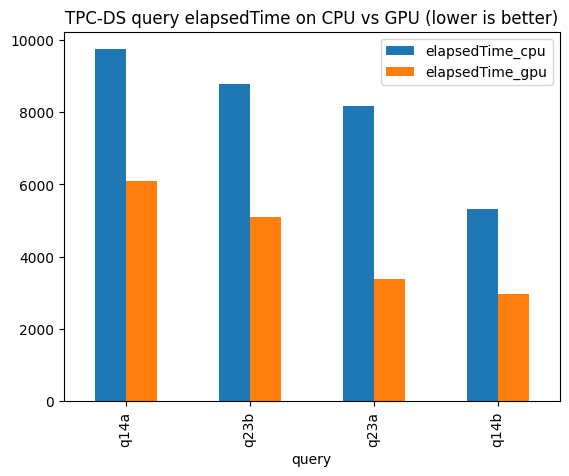

In [20]:
res.plot(title='TPC-DS query elapsedTime on CPU vs GPU (lower is better)', kind='bar', x='query', y=['elapsedTime_cpu', 'elapsedTime_gpu'])

<Axes: title={'center': 'Speedup factors of TPC-DS queries on GPU'}, xlabel='query'>

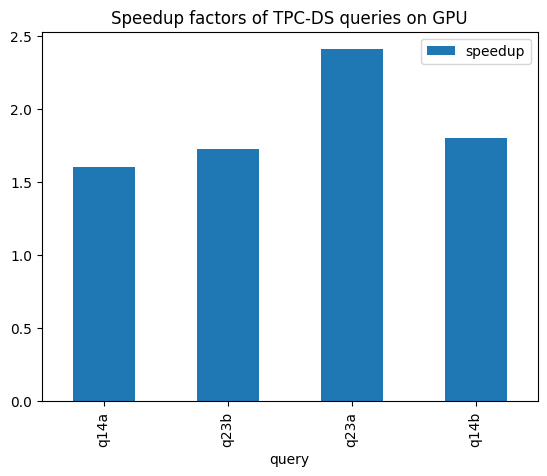

In [21]:
res.plot(title='Speedup factors of TPC-DS queries on GPU', kind='bar', x='query', y='speedup' )

# Run Queries interactively

In [22]:
query = 'q88'
with open(f"{tpcds_pyspark_files}/Queries/{query}.sql") as f:
  q = f.read()

In [23]:
print(q)

SELECT *
FROM
  (SELECT count(*) h8_30_to_9
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 8
    AND time_dim.t_minute >= 30
    AND (
    (household_demographics.hd_dep_count = 4 AND household_demographics.hd_vehicle_count <= 4 + 2)
      OR
      (household_demographics.hd_dep_count = 2 AND household_demographics.hd_vehicle_count <= 2 + 2)
      OR
      (household_demographics.hd_dep_count = 0 AND
        household_demographics.hd_vehicle_count <= 0 + 2))
    AND store.s_store_name = 'ese') s1,
  (SELECT count(*) h9_to_9_30
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 9
    AND time_dim.t_minute < 30
    AND (
    (household_demographics.hd_

In [24]:
spark.conf.set('spark.rapids.sql.enabled', True)
df  = spark.sql(q)
%time df.show()

24/10/22 16:36:57 WARN GpuOverrides: 
!Exec <ProjectExec> cannot run on GPU because not all expressions can be replaced
  @Expression <Alias> toprettystring(h8_30_to_9#70074L, Some(America/Los_Angeles)) AS toprettystring(h8_30_to_9)#70575 could run on GPU
    !Expression <ToPrettyString> toprettystring(h8_30_to_9#70074L, Some(America/Los_Angeles)) cannot run on GPU because class org.apache.spark.sql.catalyst.expressions.ToPrettyString is not supported with timezone settings: (JVM: America/Los_Angeles, session: America/Los_Angeles). Set both of the timezones to UTC to enable class org.apache.spark.sql.catalyst.expressions.ToPrettyString support
      @Expression <AttributeReference> h8_30_to_9#70074L could run on GPU
  @Expression <Alias> toprettystring(h9_to_9_30#70075L, Some(America/Los_Angeles)) AS toprettystring(h9_to_9_30)#70576 could run on GPU
    !Expression <ToPrettyString> toprettystring(h9_to_9_30#70075L, Some(America/Los_Angeles)) cannot run on GPU because class org.apache.s

+----------+----------+-----------+------------+------------+------------+------------+------------+
|h8_30_to_9|h9_to_9_30|h9_30_to_10|h10_to_10_30|h10_30_to_11|h11_to_11_30|h11_30_to_12|h12_to_12_30|
+----------+----------+-----------+------------+------------+------------+------------+------------+
|     18440|     39156|      38666|       58037|       58313|       34436|       33322|       39142|
+----------+----------+-----------+------------+------------+------------+------------+------------+

CPU times: user 12.1 ms, sys: 3.95 ms, total: 16 ms
Wall time: 2.31 s
